# Imports

In [1]:
import utils
import optuna
import inspect
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate, BaseCrossValidator
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.datasets import make_classification

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [2]:
warnings.filterwarnings("ignore")

## Functions

In [3]:
def generate_synthetic_binary_data(
    n_samples=2000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_repeated=0,
    n_classes=2,
    class_sep=1.0,
    flip_y=0.01,
    weights=None,
    test_size=0.2,
    valid_size=0.2,
    random_state=42
):
    """
    Gera dados sintéticos para problemas de classificação binária.
    
    Parâmetros
    ----------
    n_samples : int
        Número total de observações a serem geradas.
    n_features : int
        Número total de variáveis preditoras.
    n_informative : int
        Número de variáveis realmente informativas.
    n_redundant : int
        Número de variáveis redundantes (combinações lineares das informativas).
    n_repeated : int
        Número de variáveis repetidas.
    n_classes : int
        Número de classes (para binário, usar 2).
    class_sep : float
        Grau de separação entre as classes (maior valor = classes mais distintas).
    flip_y : float
        Proporção de amostras que terão o rótulo trocado aleatoriamente (ruído).
    weights : list ou None
        Distribuição de classes, ex: [0.7, 0.3] para base desbalanceada.
    test_size : float
        Proporção da base reservada para teste.
    valid_size : float
        Proporção da base de treino reservada para validação.
    random_state : int
        Semente para reprodutibilidade.
    
    Retorna
    -------
    X_train, y_train, X_valid, y_valid, X_test, y_test : pd.DataFrame
        Bases de treino, validação e teste.
    """

    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_repeated=n_repeated,
        n_classes=n_classes,
        weights=weights,
        flip_y=flip_y,
        class_sep=class_sep,
        random_state=random_state
    )

    # Cria DataFrames nomeados
    feature_names = [f"feature_{i}" for i in range(n_features)]
    X = pd.DataFrame(X, columns=feature_names)
    y = pd.DataFrame(y, columns=["target"])

    # Divide em treino/teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # Divide parte de treino em treino/validação
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=valid_size, stratify=y_train, random_state=random_state
    )

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [4]:
def get_params_space(model_name, trial, random_state=42):
    match model_name:
        case 'LightGBM':
            return {
                'objective': trial.suggest_categorical('objective', ['binary']),
                'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt']),
                'metric': trial.suggest_categorical('metric', ['auc', 'binary_logloss']),
                'num_leaves': trial.suggest_int('num_leaves', 20, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
                'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
                'random_state': trial.suggest_categorical('random_state', [random_state]),
                'verbose': trial.suggest_categorical('verbose', [-1])
            }
        case 'CatBoost':
            return {
                'loss_function': trial.suggest_categorical('loss_function', ['Logloss', 'CrossEntropy']),
                'iterations': trial.suggest_int('iterations', 100, 1000, step=100),
                'depth': trial.suggest_int('depth', 4, 10),
                'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
                'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
                'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
                'border_count': trial.suggest_int('border_count', 32, 255),
                'rsm': trial.suggest_float('rsm', 0.5, 1.0),
                'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
                'boosting_type': trial.suggest_categorical('boosting_type', ['Plain']),
                'random_seed': trial.suggest_categorical('random_seed', [random_state]),
                'verbose': trial.suggest_categorical('verbose', [0])
            }
        case 'HistGradientBoosting':
            return {
                'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
                'max_iter': trial.suggest_int('max_iter', 100, 1000, step=100),
                'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 20, 255),
                'max_depth': trial.suggest_int('max_depth', 3, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 20, 100),
                'l2_regularization': trial.suggest_float('l2_regularization', 1e-4, 10.0, log=True),
                'early_stopping': trial.suggest_categorical('early_stopping', [False]),
                'scoring': trial.suggest_categorical('scoring', ['roc_auc', 'neg_brier_score']),
                'validation_fraction': trial.suggest_float('validation_fraction', 0.1, 0.4),
                'n_iter_no_change': trial.suggest_int('n_iter_no_change', 5, 20),
                'random_state': trial.suggest_categorical('random_state', [random_state])
            }
        case 'RandomForest':
            return {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
                'max_depth': trial.suggest_int('max_depth', 3, 30),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
                'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
                'random_state': trial.suggest_categorical('random_state', [random_state]),
                'n_jobs': trial.suggest_categorical('n_jobs', [-1])
            }
        case 'GradientBoosting':
            return {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
                'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                'loss': trial.suggest_categorical('loss', ['log_loss', 'exponential']),
                'random_state': trial.suggest_categorical('random_state', [random_state])
            }
        case _:
            raise ValueError(f"Model '{model_name}' is not supported.")

In [5]:
def get_model_instance(model_name):
    match model_name:
        case 'LightGBM':
            return LGBMClassifier
        case 'CatBoost':
            return CatBoostClassifier
        case 'HistGradientBoosting':
            return HistGradientBoostingClassifier
        case 'RandomForest':
            return RandomForestClassifier
        case 'GradientBoosting':
            return GradientBoostingClassifier
        case _:
            raise ValueError(f"Model '{model_name}' is not suported.")

## Data Base

In [6]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_synthetic_binary_data(
    n_samples=10000,
    n_features=30,
    n_informative=5,
    n_redundant=10,
    n_repeated=0,
    n_classes=2,
    class_sep=0.5,   # classes mais misturadas
    flip_y=0.15,     # ruído nos rótulos
    weights=[0.8, 0.2],  # desbalanceamento
    test_size=0.2,
    valid_size=0.2,
    random_state=42
)

In [7]:
rfe = SequentialFeatureSelector(
    XGBClassifier(verbose=-1), 
    n_features_to_select=15, 
    direction='backward',
    scoring='neg_log_loss', 
    cv=3
)
rfe.fit(X_train, y_train['target'])
best_features_reg = X_train.loc[:, rfe.get_support()].columns.tolist()

# Classifier

In [8]:
class AutoMLClassifier:
    def __init__(
        self, X_train, y_train, X_valid, y_valid, X_test, y_test, model_name, target='target', 
        scoring='roc_auc', cv=None, features=None, tune=False, params_space=None, n_trials=50, random_state=42):
        
        self.X_train = X_train
        self.y_train = y_train
        self.X_valid = X_valid
        self.y_valid = y_valid
        self.X_test = X_test
        self.y_test = y_test
        self.cv = cv
        self.tune = tune
        self.target = target
        self.n_trials = n_trials
        self.model_name = model_name
        self.model_instance = get_model_instance(model_name)
        self.features = features if features else self.X_train.columns.tolist()
        self.scorer = utils.get_class_eval_scoring(scoring, return_func=False)
        self.func_metric = utils.get_class_eval_scoring(scoring, return_func=True)
        self.random_state = random_state

    def _get_best_params(self):
        def objective(trial):
            params = get_params_space(self.model_name, trial, self.random_state)
            model = self.model_instance(**params)
            if isinstance(self.cv, (int, BaseCrossValidator)):
                cv_results = cross_validate(
                    estimator=model, 
                    X=self.X_train[self.features],
                    y=self.y_train[self.target],
                    cv=self.cv,
                    scoring=self.scorer
                )
                return np.mean(cv_results['test_score'])
            
            model.fit(self.X_train[self.features], self.y_train[self.target])
            preds = model.predict(self.X_valid[self.features])
            return self.func_metric(self.y_valid[self.target], preds)
        
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=self.n_trials)
        return study.best_params
    
    def _cross_validate(self, model):
        cv_results = cross_validate(
            estimator=model, 
            X=self.X_train[self.features], 
            y=self.y_train[self.target], 
            cv=self.cv,
            scoring={
                'balanced_accuracy': 'balanced_accuracy', 
                'precision': 'precision', 
                'recall': 'recall', 
                'f1': 'f1', 
                'roc_auc': 'roc_auc', 
                'ks': utils.ks_scorer, 
                'brier': 'neg_brier_score',
                'log_loss': 'neg_log_loss'
            }
        )
        return {
            'Balanced Accuracy': cv_results['test_balanced_accuracy'].mean(),
            'Precision': cv_results['test_precision'].mean(),
            'Recall': cv_results['test_recall'].mean(),
            'F1': cv_results['test_f1'].mean(),
            'AUC': cv_results['test_roc_auc'].mean(),
            'KS': cv_results['test_ks'].mean(),
            'Brier': np.abs(cv_results['test_brier'].mean()),
            'LogLoss': np.abs(cv_results['test_log_loss'].mean())
        }
    
    def _fit(self):
        model_sig = inspect.signature(self.model_instance).parameters
        init_params = {}
        if 'random_state' in model_sig:
            init_params['random_state'] = self.random_state
        if 'verbose' in model_sig:
            init_params['verbose'] = 0
        elif 'verbosity' in model_sig:
            init_params['verbosity'] = -1

        params = self._get_best_params() if self.tune else init_params
        model = self.model_instance(**params)

        if isinstance(self.cv, (int, BaseCrossValidator)):
            results = {'Train CV': self._cross_validate(model)}
            model.fit(self.X_train[self.features], self.y_train[self.target])
            self.y_test['pred'] = model.predict(self.X_test[self.features])
            self.y_test['prob'] = model.predict_proba(self.X_test[self.features])[:, 1]
            results['Test'] = utils.get_class_metrics(self.y_test, 'pred', 'prob', self.target)
            return model, results

        fit_sig = inspect.signature(model.fit).parameters
        fit_args = {'X': self.X_train[self.features], 'y': self.y_train[self.target]}
        if 'eval_set' in fit_sig and self.X_valid is not None:
            fit_args['eval_set'] = [(self.X_valid[self.features], self.y_valid[self.target])]
        if 'early_stopping_rounds' in fit_sig:
            fit_args['early_stopping_rounds'] = 50

        model.fit(**fit_args)

        self.y_train['pred'] = model.predict(self.X_train[self.features])
        self.y_train['prob'] = model.predict_proba(self.X_train[self.features])[:, 1]
        
        self.y_valid['pred'] = model.predict(self.X_valid[self.features])
        self.y_valid['prob'] = model.predict_proba(self.X_valid[self.features])[:, 1]
        
        self.y_test['pred'] = model.predict(self.X_test[self.features])
        self.y_test['prob'] = model.predict_proba(self.X_test[self.features])[:, 1]

        results = {
            'Train': utils.get_class_metrics(self.y_train, 'pred', 'prob', self.target),
            'Valid': utils.get_class_metrics(self.y_valid, 'pred', 'prob', self.target),
            'Test': utils.get_class_metrics(self.y_test, 'pred', 'prob', self.target)
        }
        return model, results

    def train(self):
        self.model, self.results = self._fit()

    def get_metrics(self, return_df=True):
        return pd.DataFrame(self.results).T if return_df else self.results
    
    def get_result_analysis(self):
        display(self.get_metrics())
        utils.analyze_class_model(
            self.model, self.features, 
            self.X_train, self.y_train, self.y_test, self.target, self.scorer
        )

## Base Model

In [9]:
a = AutoMLClassifier(
    X_train, 
    y_train, 
    X_valid, 
    y_valid,
    X_test, 
    y_test,
    model_name='HistGradientBoosting',
    scoring='log_loss'
)

In [10]:
a.train()

In [11]:
a.get_metrics()

,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier,LogLoss
Train,0.889079,0.984578,0.782076,0.871721,0.994511,0.929641,0.047849,0.191830
Valid,0.703600,0.776786,0.448454,0.568627,0.810456,0.494029,0.126698,0.414377
Test,0.703331,0.763066,0.451546,0.567358,0.823512,0.532789,0.124933,0.408922


,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier,LogLoss
Train,0.889079,0.984578,0.782076,0.871721,0.994511,0.929641,0.047849,0.191830
Valid,0.703600,0.776786,0.448454,0.568627,0.810456,0.494029,0.126698,0.414377
Test,0.703331,0.763066,0.451546,0.567358,0.823512,0.532789,0.124933,0.408922


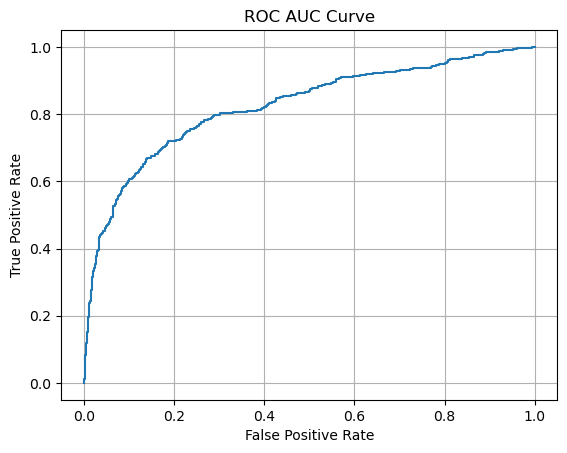

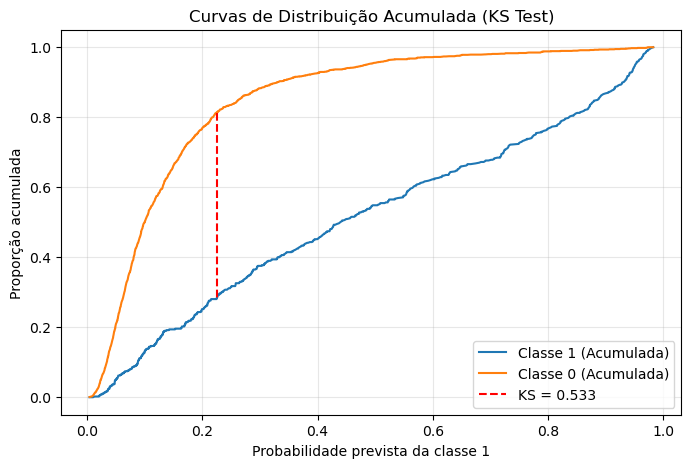

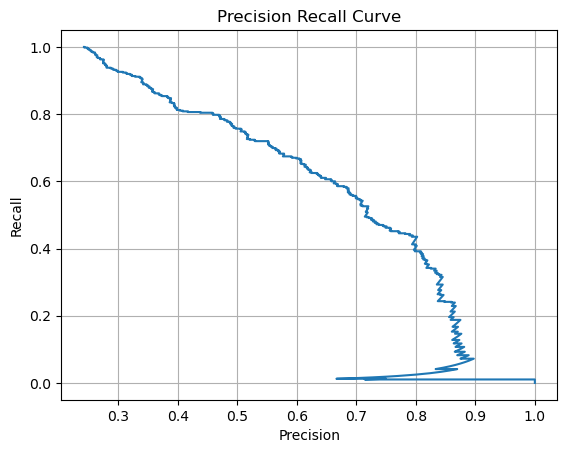

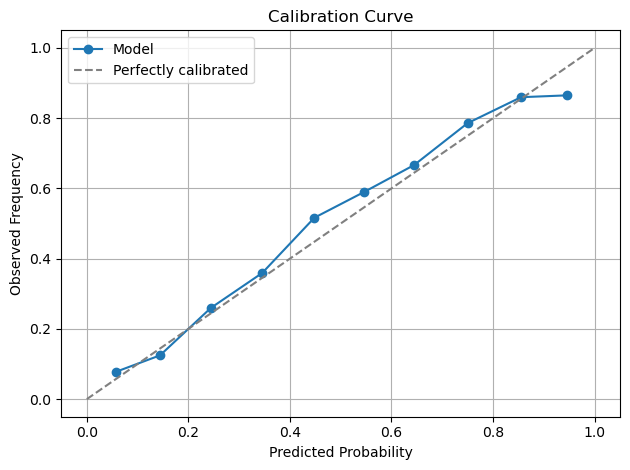

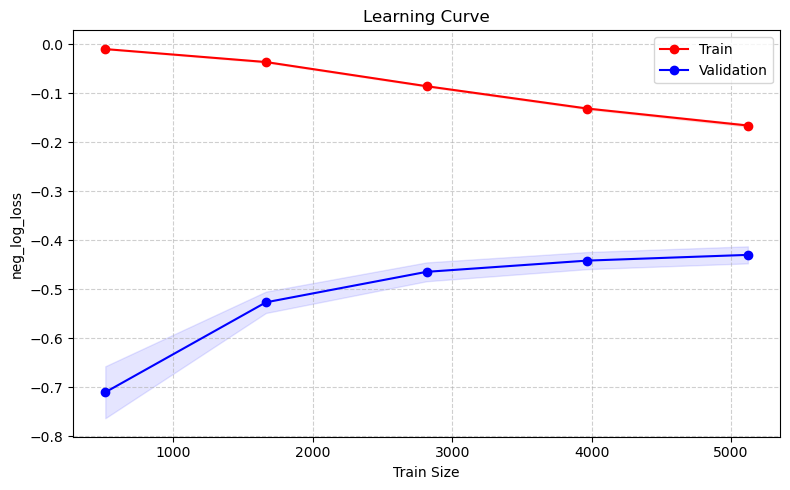

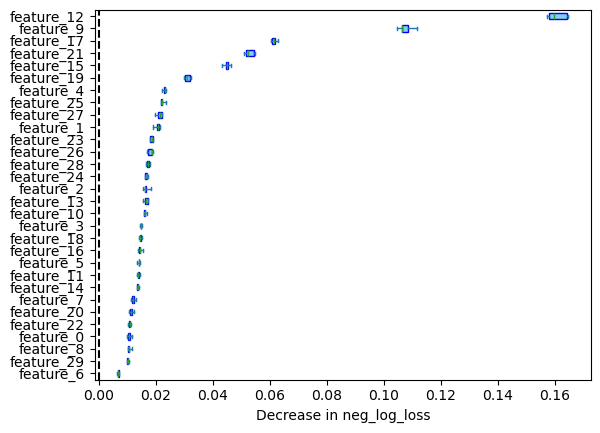

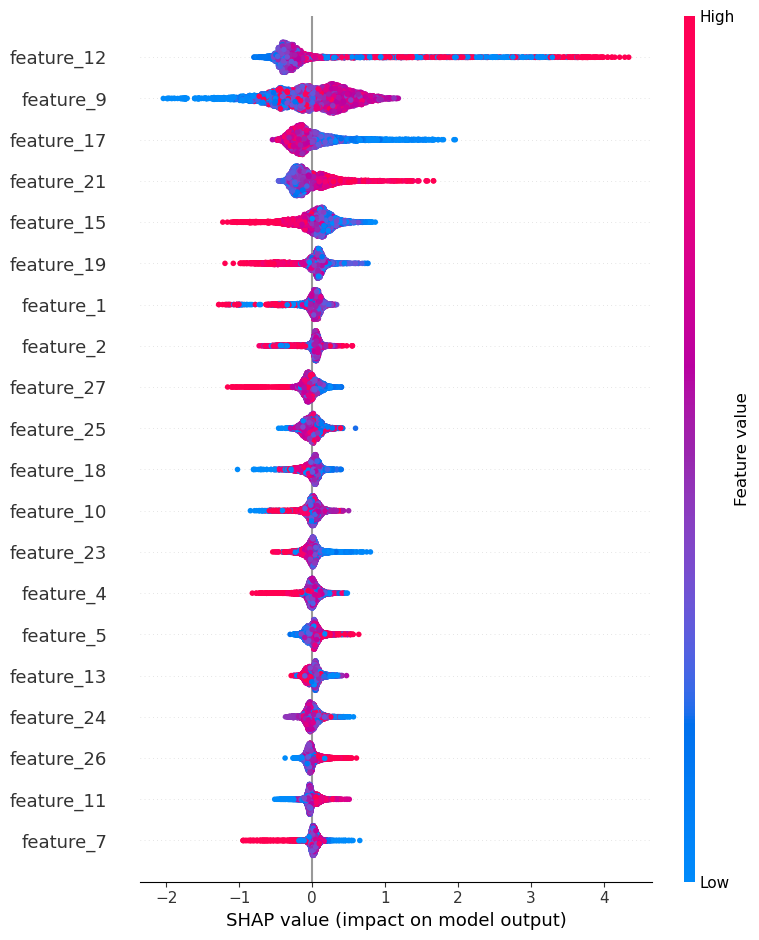

In [12]:
a.get_result_analysis()

## Feature Selection Model

In [14]:
a = AutoMLClassifier(
    X_train, 
    y_train, 
    X_valid, 
    y_valid,
    X_test,
    y_test,
    model_name='CatBoost',
    features=best_features_reg,
    scoring='log_loss'
)

In [15]:
a.train()

In [16]:
a.get_metrics()

,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier,LogLoss
Train,0.753686,0.896817,0.526757,0.663688,0.919296,0.676824,0.095668,0.320655
Valid,0.700355,0.822660,0.430412,0.565144,0.824562,0.540667,0.123125,0.401499
Test,0.702096,0.800752,0.439175,0.567244,0.836263,0.570481,0.120788,0.397659


,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier,LogLoss
Train,0.753686,0.896817,0.526757,0.663688,0.919296,0.676824,0.095668,0.320655
Valid,0.700355,0.822660,0.430412,0.565144,0.824562,0.540667,0.123125,0.401499
Test,0.702096,0.800752,0.439175,0.567244,0.836263,0.570481,0.120788,0.397659


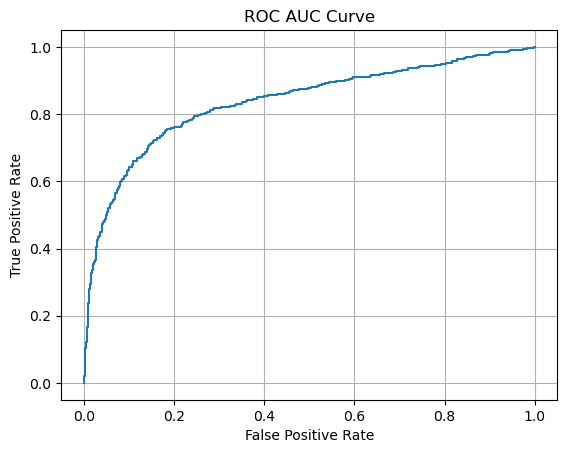

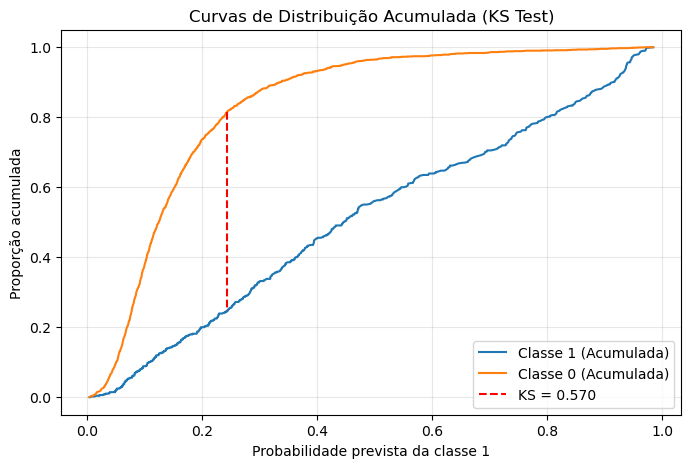

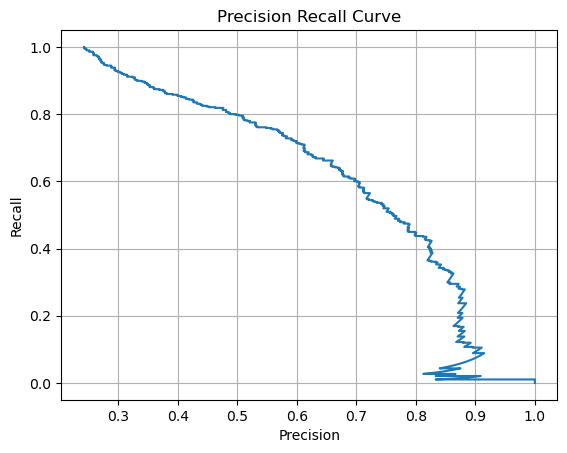

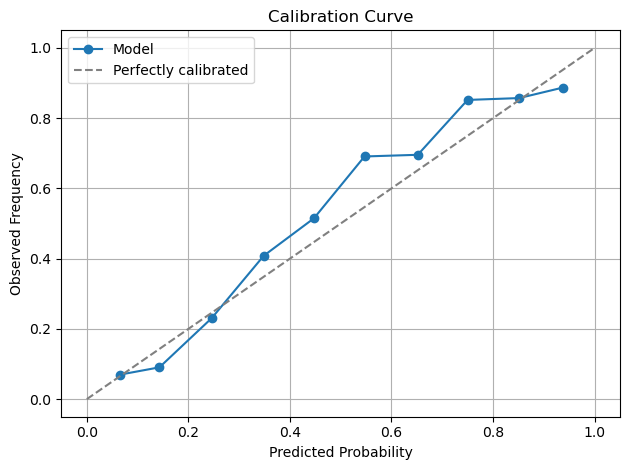

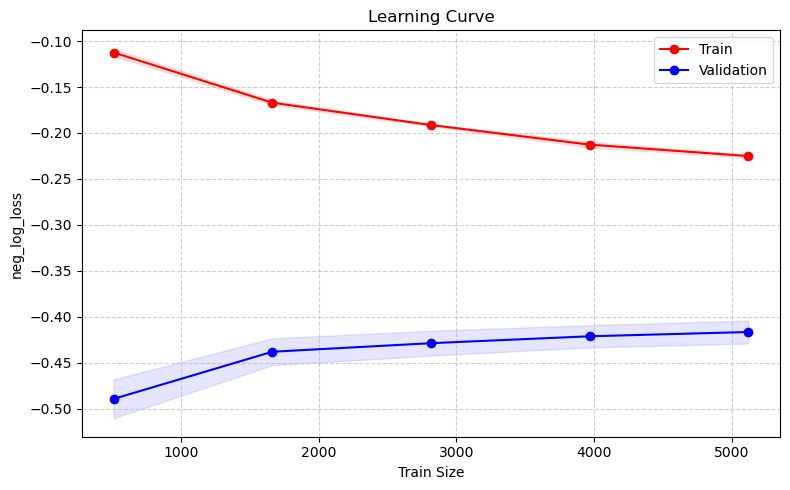

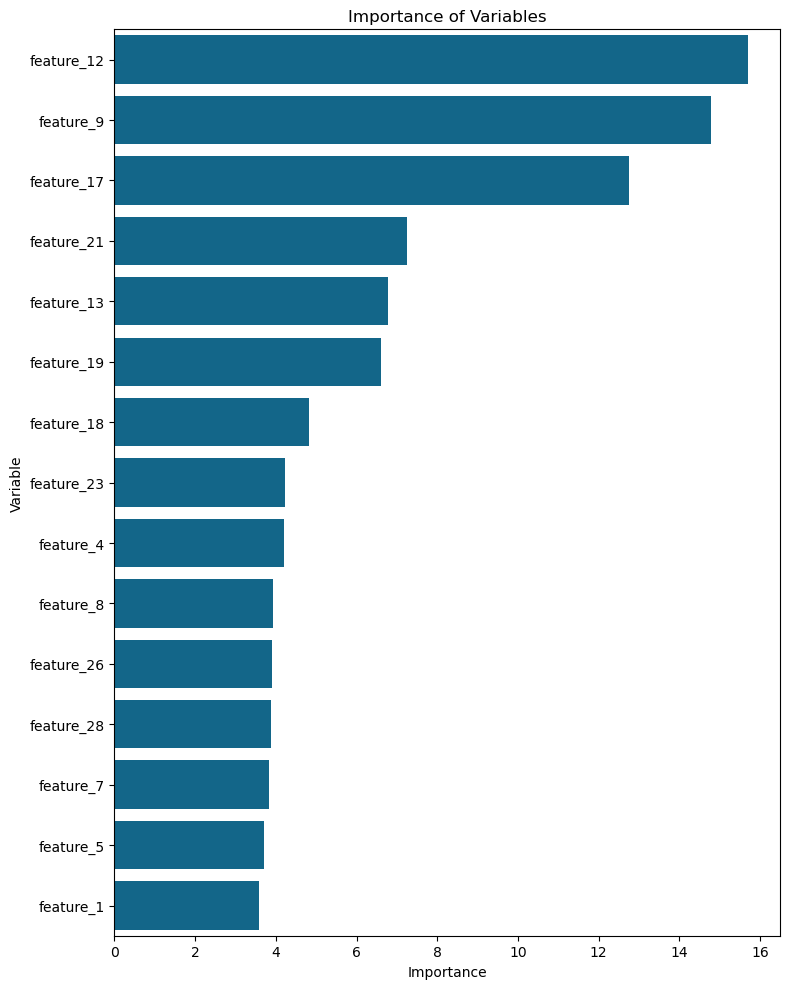

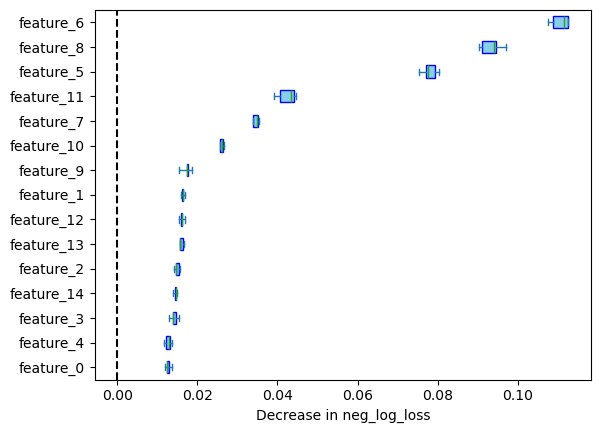

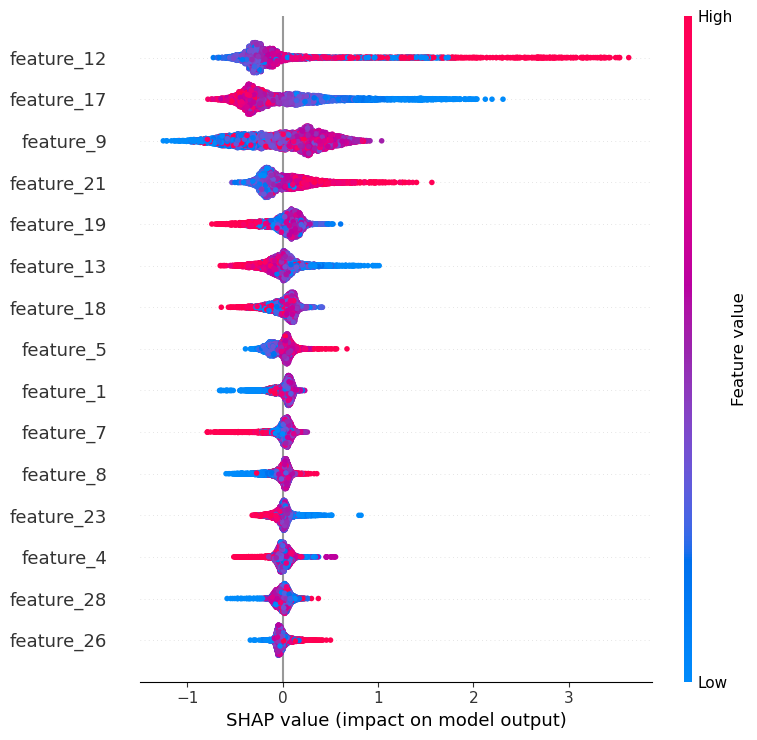

In [17]:
a.get_result_analysis()

## Hiperparameter Fine Tuning

In [18]:
a = AutoMLClassifier(
    X_train, 
    y_train, 
    X_valid, 
    y_valid,
    X_test,
    y_test,
    model_name='CatBoost',
    tune=True,
    features=best_features_reg,
    scoring='log_loss'
)

In [19]:
a.train()

In [20]:
a.get_metrics()

,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier,LogLoss
Train,0.853450,0.995467,0.707930,0.827430,0.989409,0.877222,0.055582,0.213981
Valid,0.702107,0.816425,0.435567,0.568067,0.818352,0.520763,0.122257,0.399605
Test,0.709683,0.800725,0.455670,0.580815,0.835957,0.571481,0.118305,0.389960


,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier,LogLoss
Train,0.853450,0.995467,0.707930,0.827430,0.989409,0.877222,0.055582,0.213981
Valid,0.702107,0.816425,0.435567,0.568067,0.818352,0.520763,0.122257,0.399605
Test,0.709683,0.800725,0.455670,0.580815,0.835957,0.571481,0.118305,0.389960


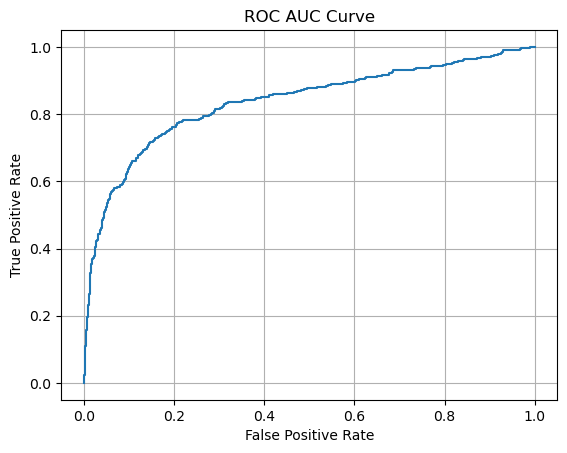

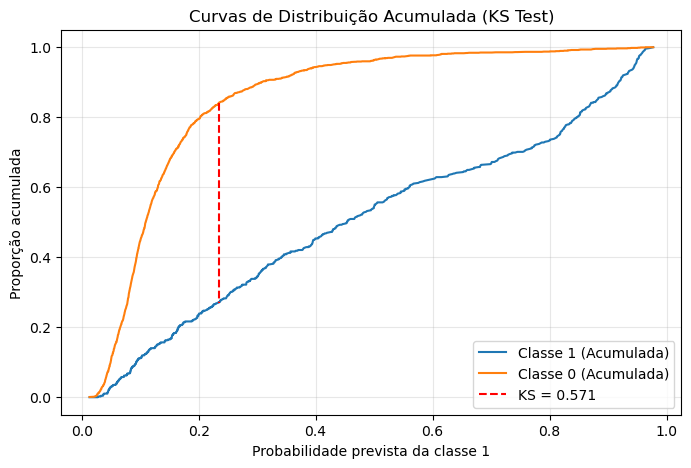

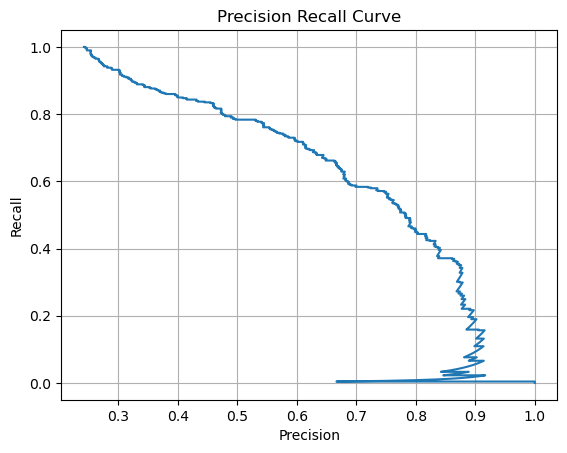

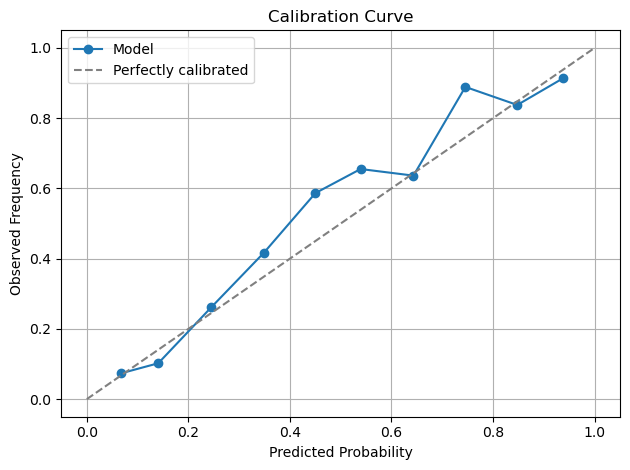

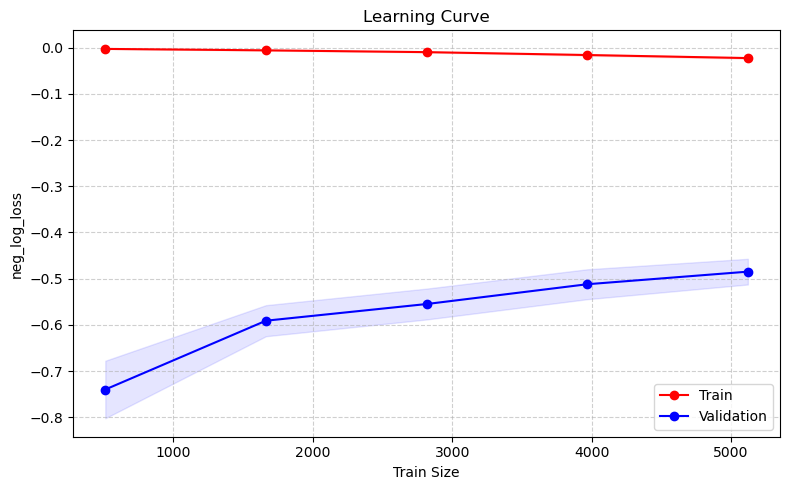

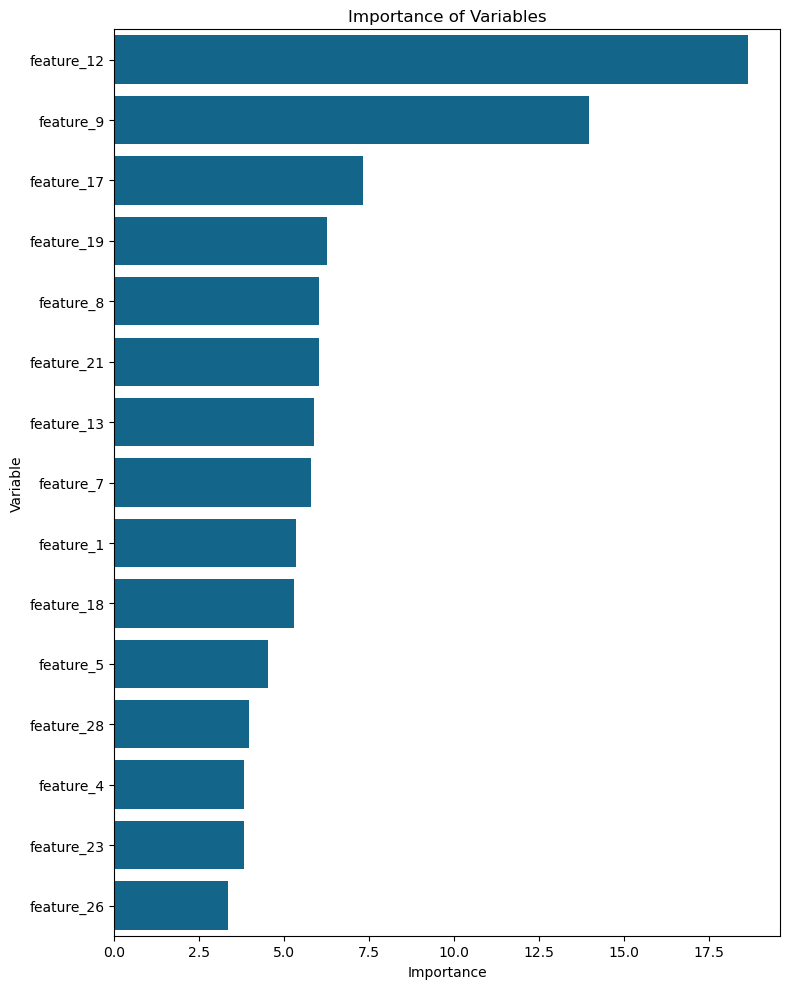

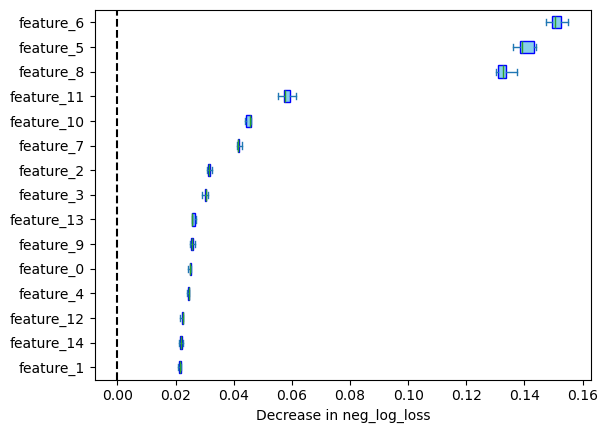

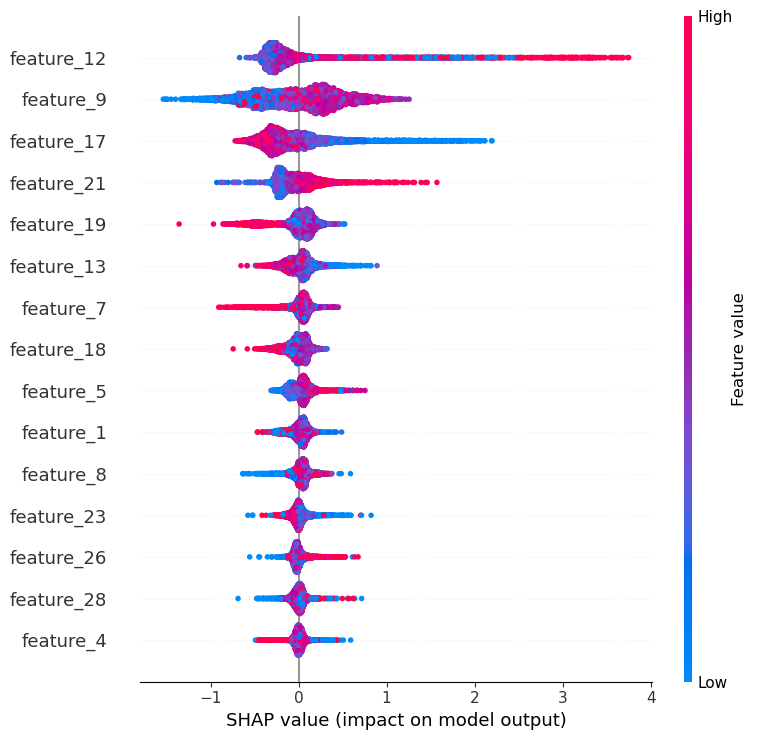

In [21]:
a.get_result_analysis()

## Base Model (CV)

In [22]:
a = AutoMLClassifier(
    X_train, 
    y_train,
    X_valid=None,
    y_valid=None,
    X_test=X_test,
    y_test=y_test,
    cv=5,
    model_name='LightGBM',
    target='target',
    scoring='log_loss'
)

In [23]:
a.train()

[LightGBM] [Info] Number of positive: 1241, number of negative: 3879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242383 -> initscore=-1.139660
[LightGBM] [Info] Start training from score -1.139660
[LightGBM] [Info] Number of positive: 1241, number of negative: 3879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242383 -> initscore=-1.139660
[LightGBM] [Info] Start training from score -1.139660
[LightGBM] [Info] 

In [24]:
a.get_metrics()

,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier,LogLoss
Train CV,0.687861,0.741950,0.422950,0.538259,0.801892,0.488805,0.131155,0.427553
Test,0.707866,0.755034,0.463918,0.574713,0.825718,0.547222,0.123760,0.405967


,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier,LogLoss
Train CV,0.687861,0.741950,0.422950,0.538259,0.801892,0.488805,0.131155,0.427553
Test,0.707866,0.755034,0.463918,0.574713,0.825718,0.547222,0.123760,0.405967


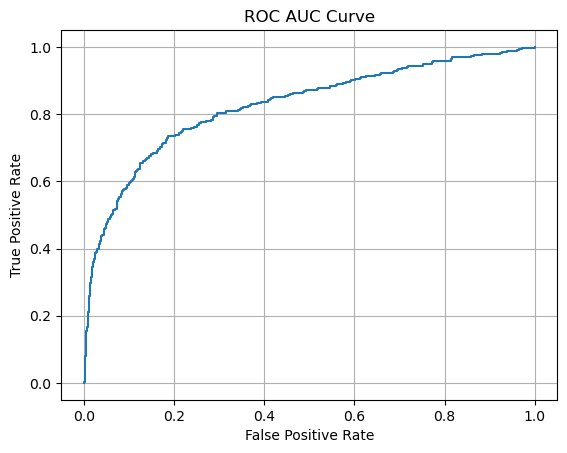

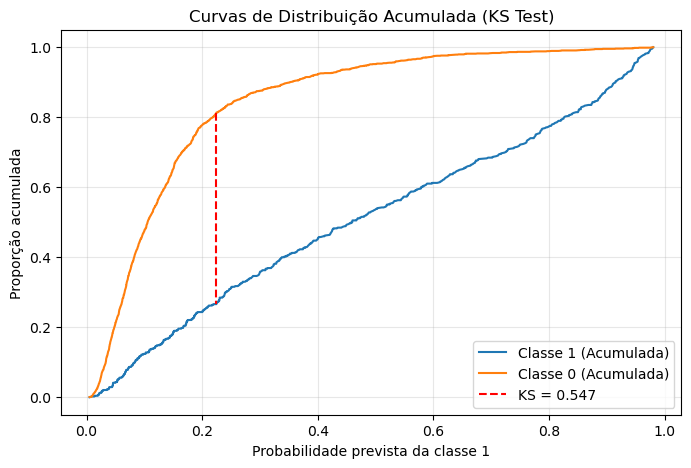

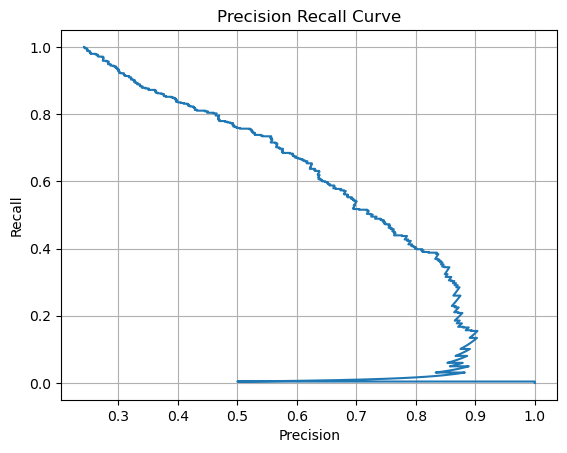

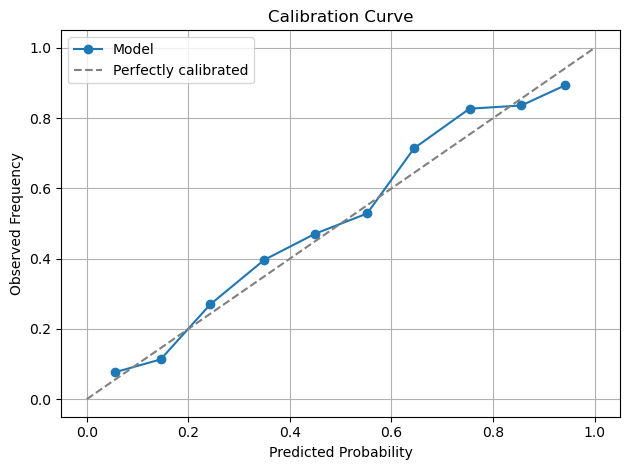

[LightGBM] [Info] Number of positive: 107, number of negative: 405
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5130
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208984 -> initscore=-1.331058
[LightGBM] [Info] Start training from score -1.331058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

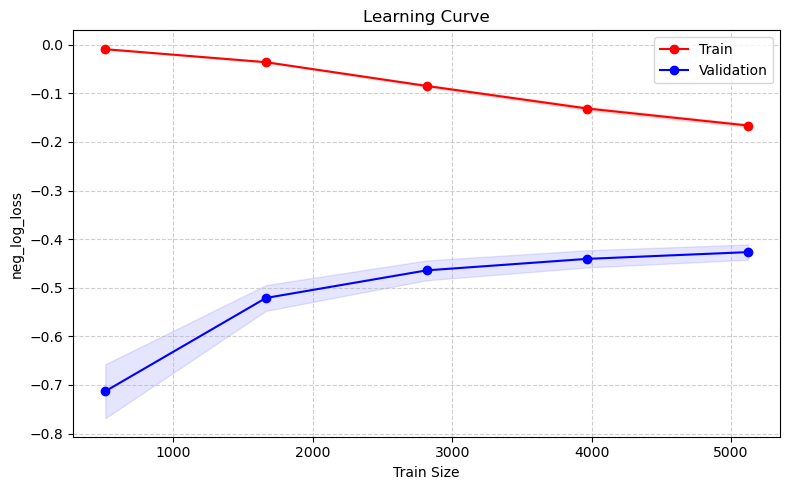

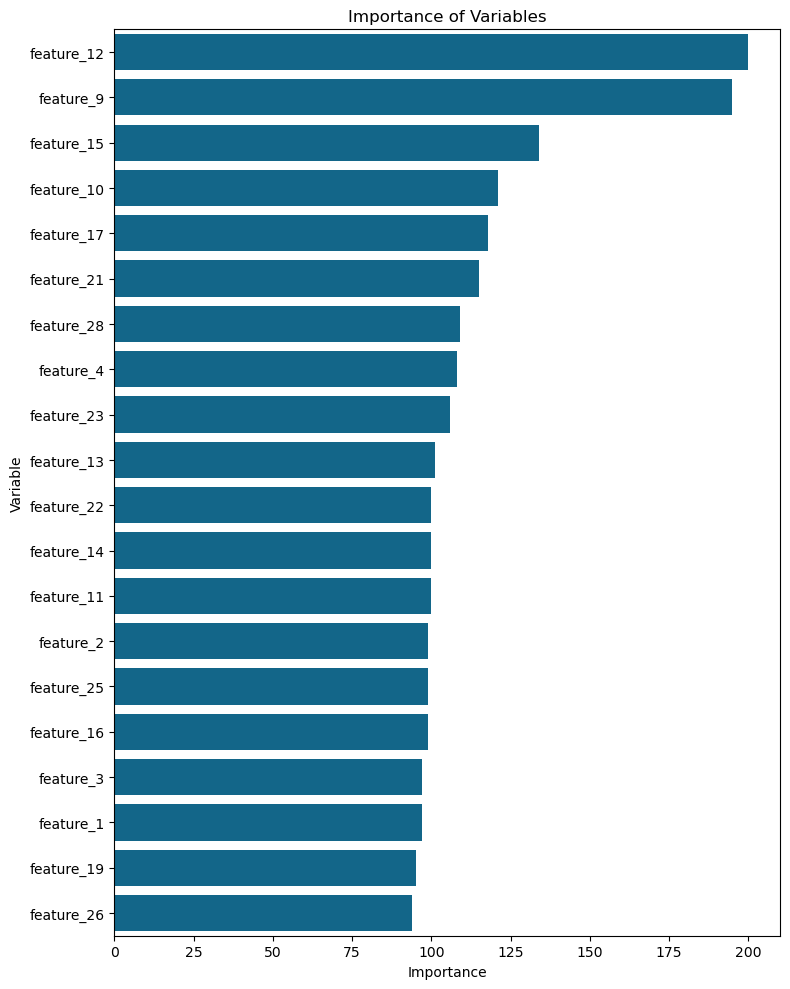

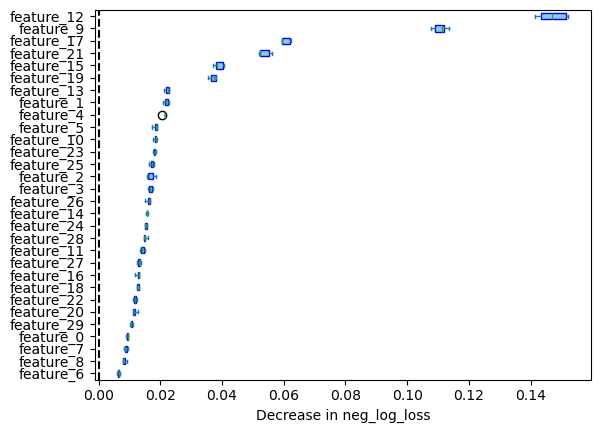

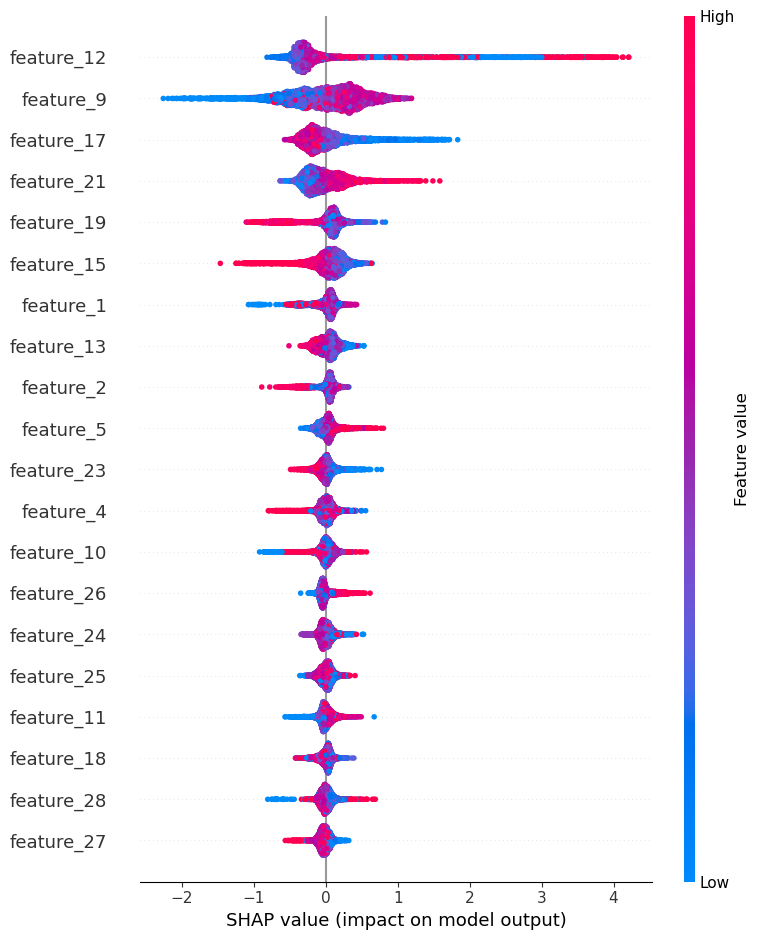

In [25]:
a.get_result_analysis()

## Feature Selection (CV)

In [26]:
a = AutoMLClassifier(
    X_train, 
    y_train,
    X_valid=None,
    y_valid=None,
    X_test=X_test,
    y_test=y_test,
    cv=5,
    model_name='LightGBM',
    target='target',
    scoring='log_loss',
    features=best_features_reg
)

In [27]:
a.train()

[LightGBM] [Info] Number of positive: 1241, number of negative: 3879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242383 -> initscore=-1.139660
[LightGBM] [Info] Start training from score -1.139660
[LightGBM] [Info] Number of positive: 1241, number of negative: 3879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242383 -> initscore=-1.139660
[LightGBM] [Info] Start training from score -1.139660
[LightGBM] [Info] 

In [28]:
a.get_metrics()

,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier,LogLoss
Train CV,0.697713,0.738291,0.446159,0.555922,0.801709,0.492668,0.131327,0.427464
Test,0.713640,0.771044,0.472165,0.585678,0.825631,0.539907,0.122396,0.405512


,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier,LogLoss
Train CV,0.697713,0.738291,0.446159,0.555922,0.801709,0.492668,0.131327,0.427464
Test,0.713640,0.771044,0.472165,0.585678,0.825631,0.539907,0.122396,0.405512


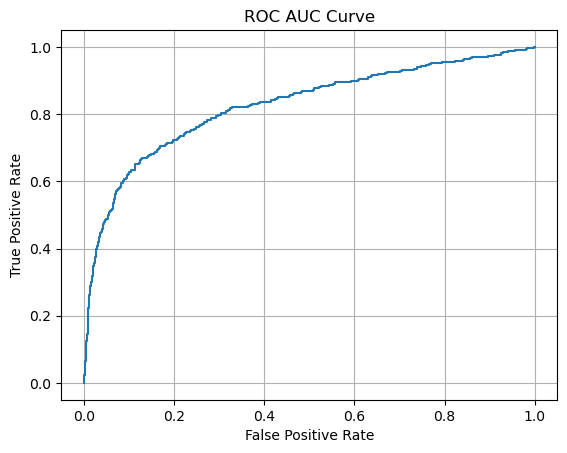

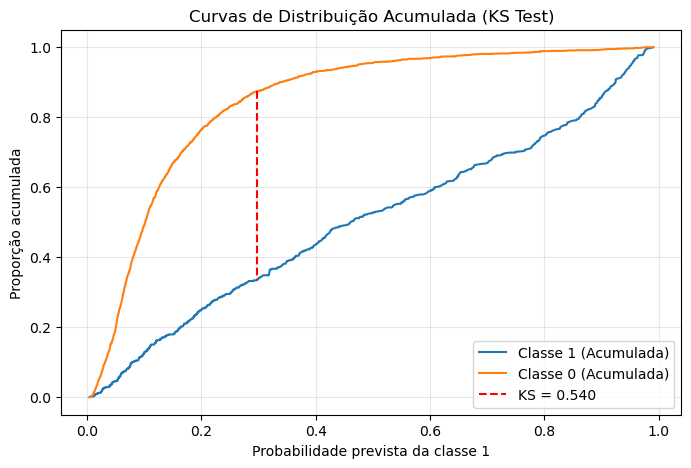

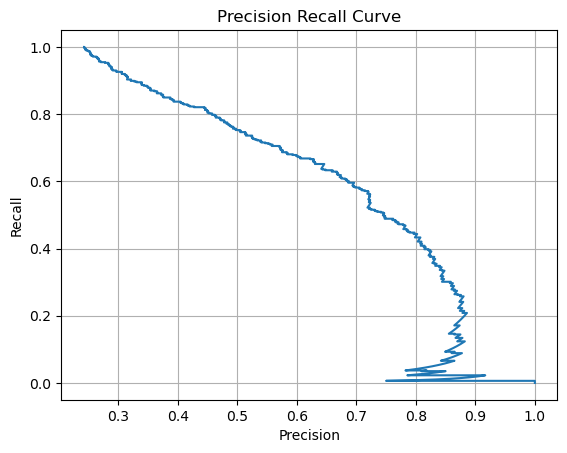

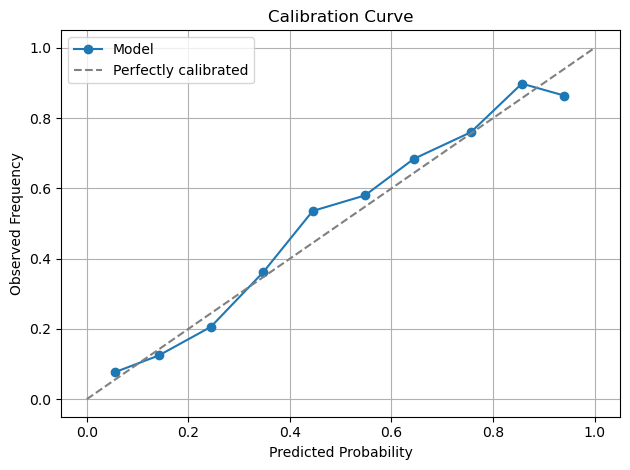

[LightGBM] [Info] Number of positive: 107, number of negative: 405
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5130
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208984 -> initscore=-1.331058
[LightGBM] [Info] Start training from score -1.331058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

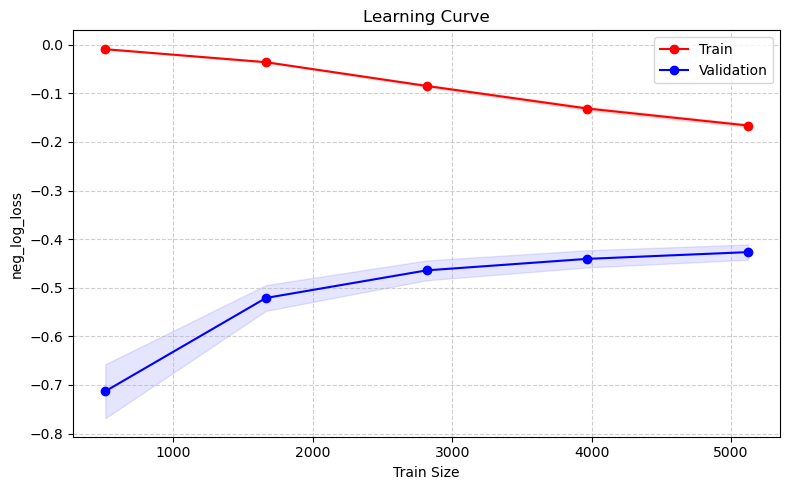

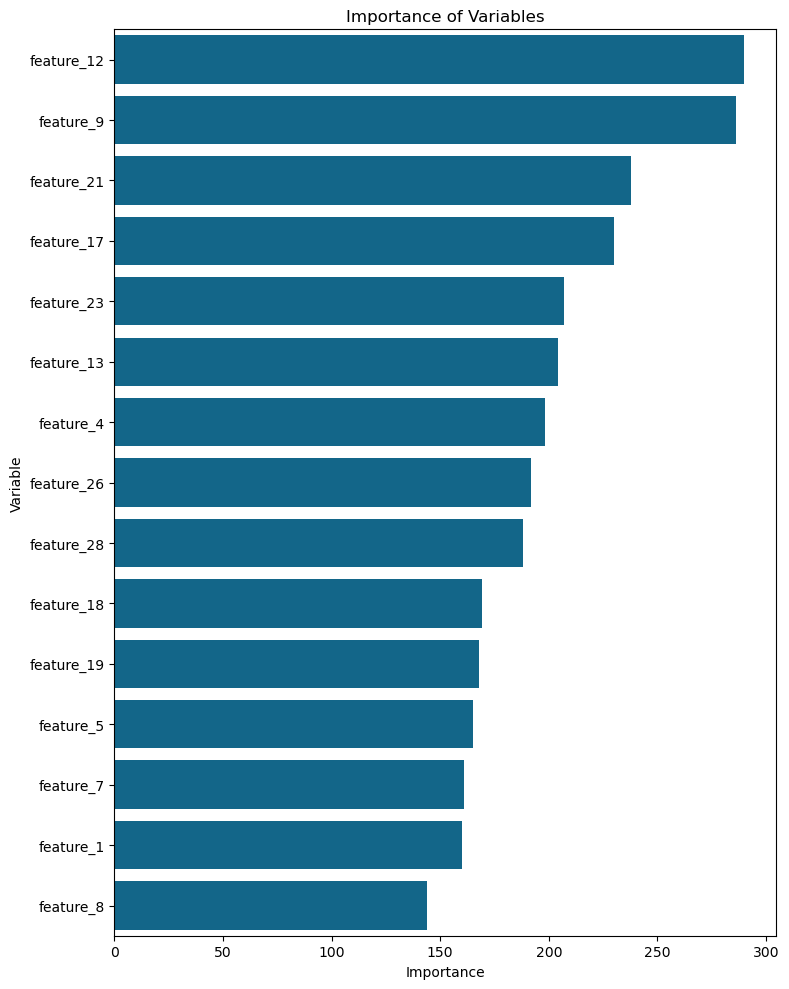

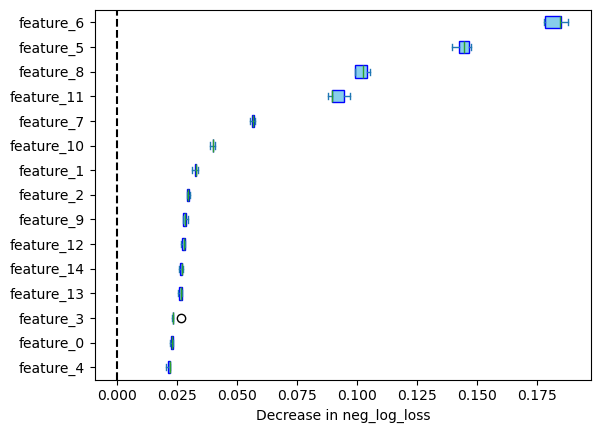

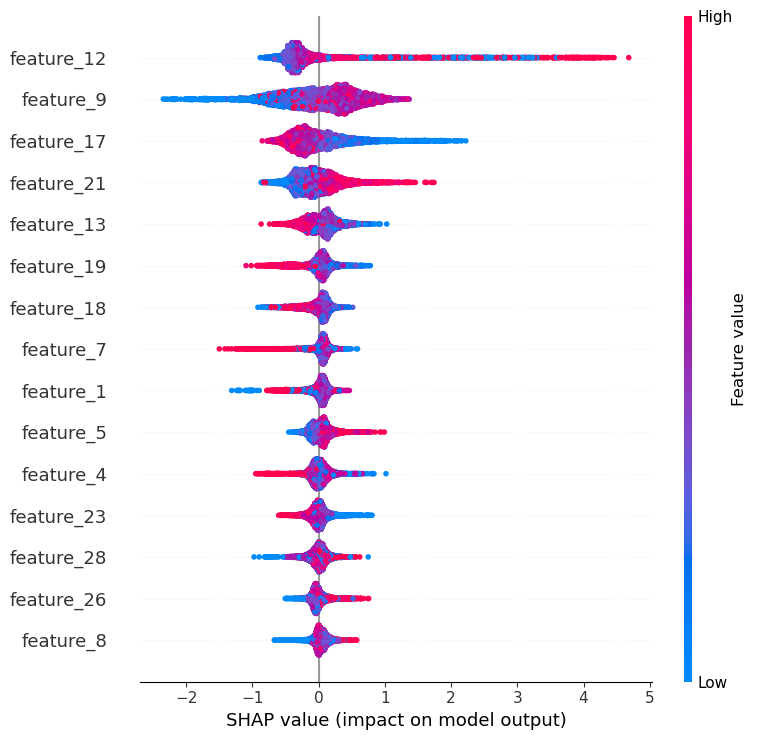

In [29]:
a.get_result_analysis()

## Hiperparameter Fine Tuning (CV)

In [30]:
a = AutoMLClassifier(
    X_train, 
    y_train,
    X_valid=None,
    y_valid=None,
    X_test=X_test,
    y_test=y_test,
    cv=5,
    tune=True,
    model_name='CatBoost',
    target='target',
    scoring='log_loss',
    features=best_features_reg
)

In [31]:
a.train()

In [32]:
a.get_metrics()

,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier,LogLoss
Train CV,0.688889,0.791953,0.412631,0.542147,0.816841,0.522064,0.126321,0.410044
Test,0.702096,0.800752,0.439175,0.567244,0.839618,0.576680,0.118592,0.390546


,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier,LogLoss
Train CV,0.688889,0.791953,0.412631,0.542147,0.816841,0.522064,0.126321,0.410044
Test,0.702096,0.800752,0.439175,0.567244,0.839618,0.576680,0.118592,0.390546


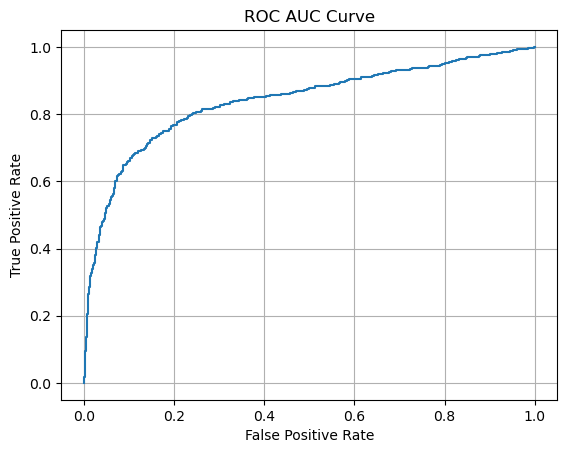

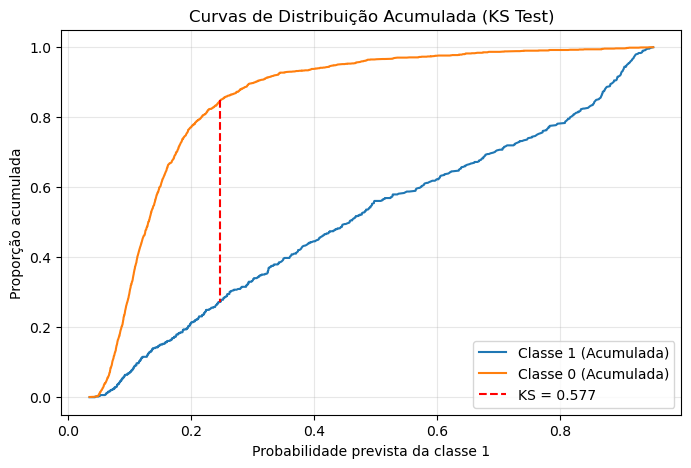

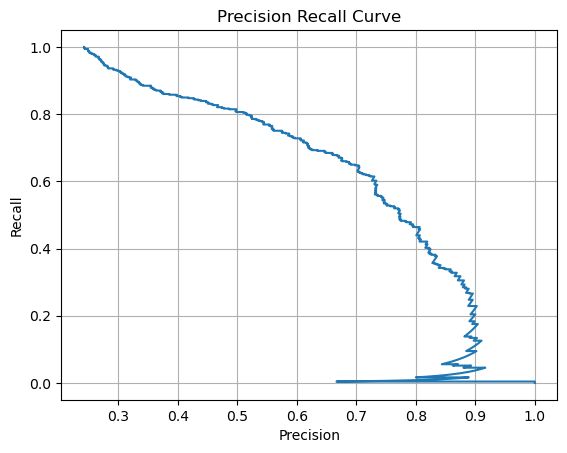

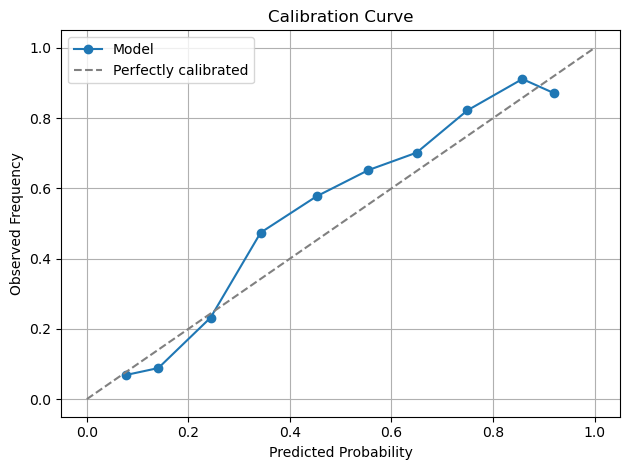

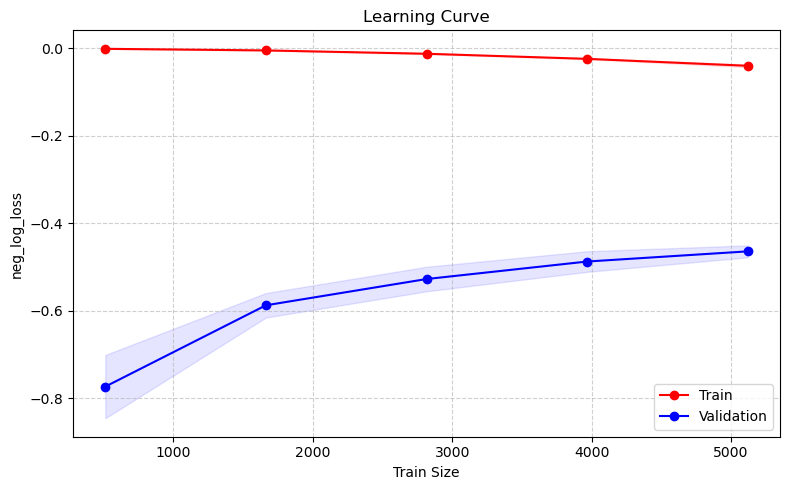

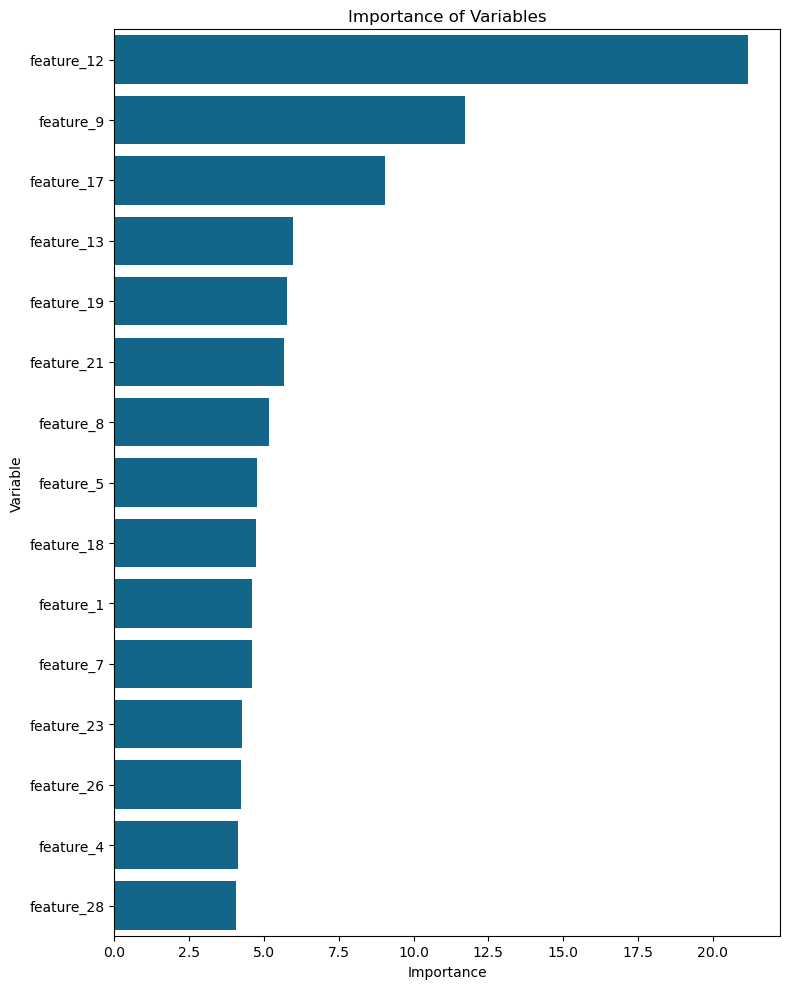

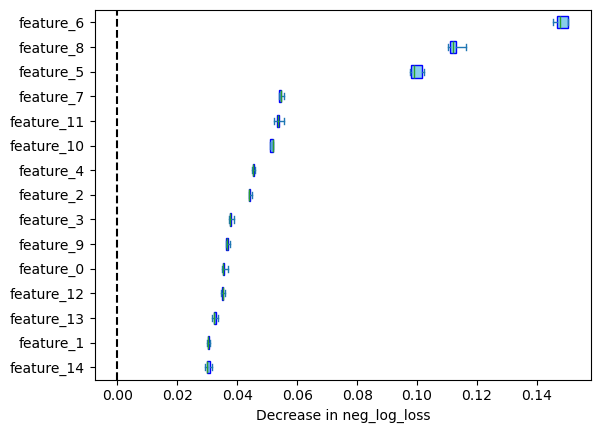

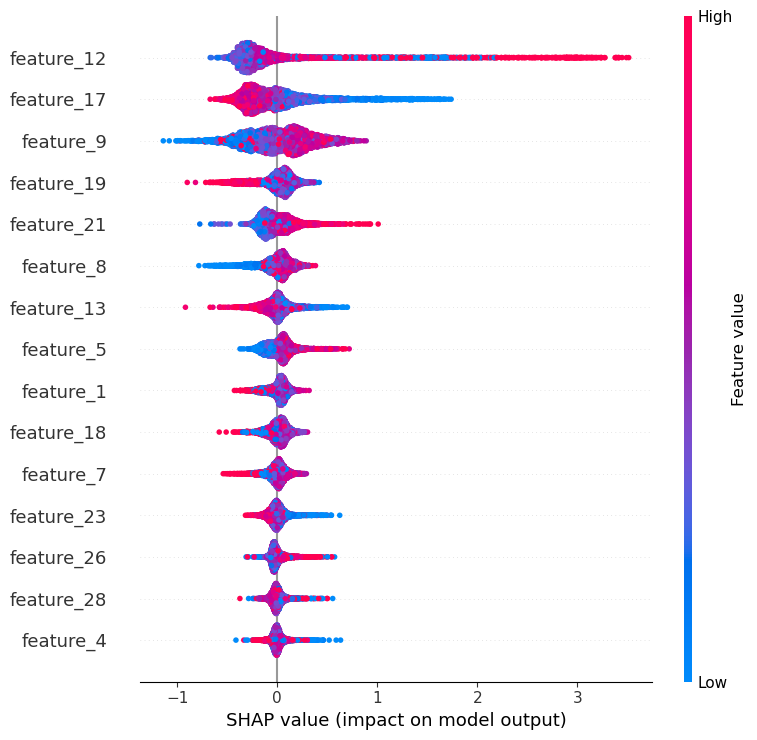

In [33]:
a.get_result_analysis()